Ideally THD would say: 0,0,25%,50%,inf


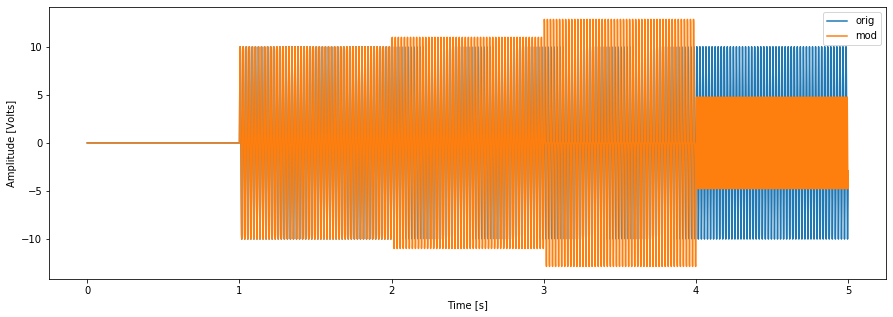

In [2]:
#Generate simulated data
import numpy as np
import matplotlib.pyplot as plt

fs = 1000

f = 50
t = 1
time = np.arange(t * fs) / fs
signal0 = np.zeros(len(time))
signal1 = 10 * np.sin(2 * np.pi * f * time) 
signal2 = 2.5 * np.sin(2 * np.pi * f*2 * time) 
signal3 = 5 * np.sin(2 * np.pi * f*2 * time)
finalSignalOrig = np.concatenate((signal0,signal1,signal1,signal1,signal1))
finalSignalMod = np.concatenate((signal0,signal1,signal1+signal2,signal1+signal3,signal3))
finalTime = np.arange(t * fs * 5) / fs
print("Ideally THD would say: 0,0,25%,50%,inf")

# finalSignal = np.concatenate((signal1,signal1+signal2))
# finalTime = np.arange(t * fs*2) / fs
plt.figure(figsize=(15, 5))
plt.plot(finalTime,finalSignalOrig, label = "orig")
plt.plot(finalTime,finalSignalMod, label = "mod")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude [Volts]")
#plt.xlim((0,.1))
plt.legend()
plt.show()

In [4]:
#Compute THDSI. NOTE you need to run the below cell first for the funds

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

finalSignalOrig = np.concatenate((signal0,signal1,signal1,signal1,signal1))
finalSignalMod = np.concatenate((signal0,signal1,signal1+signal2,signal1+signal3,signal3))
# finalTime = np.arange(t * fs * 5) / fs

binsize = 100
overlapFac = 0.5
threshold = 1

xAxis, yAxis, cleanSTFT = simpleStft(finalSignalOrig, fs, binsize=binsize, overlapFac=overlapFac, Zlog=False , plot=True, colormap="jet")
_, _, noisySTFT = simpleStft(finalSignalMod, fs, binsize=binsize, overlapFac=overlapFac, Zlog=False , plot=True, colormap="jet")
THDSIvals, THDSINvals, harmonicVals, fundFreqs = THDSI(cleanSTFT,noisySTFT, yAxis, binsize, threshold = threshold, overlapFac=overlapFac, fs=fs)


fig, axx = plt.subplots(2, 1, figsize=(10, 5))
axx[0].set_title('Detected fundamental frequencies')
axx[0].set_xlabel('Time [s]')
axx[0].set_ylabel('Freq [Hz]')
axx[0].grid('y')
axx[0].set_xlim((0,5))
axx[0].set_ylim((0,100))
axx[0].plot(xAxis,fundFreqs)
axx[1].set_title('THDSI')
axx[1].set_xlabel('Time [s]')
axx[1].set_ylabel('THD [%]')
axx[1].set_xlim((0,5))
axx[1].set_ylim((0,100))
axx[1].grid('y')
axx[1].plot(xAxis,THDSIvals)
plt.tight_layout()
plt.show()

NameError: name 'simpleStft' is not defined

In [3]:
import numpy as np
from scipy.signal import decimate
from scipy.signal import butter
from scipy.signal import butter, lfilter, freqz
from math import floor

def THDSI(cleanFFT, NoisyFFT, yAxis, binsize, threshold = 2, overlapFac=0,fs = None, TF = None):
    assert (np.shape(cleanFFT) == np.shape(NoisyFFT)),"Clean and Noisy signals are not the exact same length"
   
    #if fs:
#         print("Freq res: {:.2f} [Hz]".format(fs/binsize))
#         print("FFT Frame size: {:.0f} [ms]".format(binsize/fs*1000))
#         if overlapFac != 0:
#             print("Increment between FFTs is {} [ms] - {}% overlap".format((binsize/fs*1000)*overlapFac,overlapFac*100))
#         else:
#             print("Increment between FFTs is {} [ms] - {}% overlap".format((binsize/fs*1000),overlapFac*100))

    THDSIvals = []
    THDNSIvals = []
    harmonicVals = []
    fundFreqs = []
    ACF = 1/np.mean(np.hanning(binsize)) #1/mean
    ECF = 1/np.sqrt(np.mean(np.hanning(binsize)**2)) #1/rms
    for currCol, (cleanFFTData, noisyFFTData) in enumerate(zip(cleanFFT.T, NoisyFFT.T)):
#         if (currCol % 100) == 0:
#             verbose = True
#             print("THDSIng STFT idx {}...".format(currCol))
        maxIdx = cleanFFTData.argmax()
#         if verbose:
#             print("max Idx = {}".format(maxIdx))

        if np.any(TF):
            #Compute corrected STFT from CNT transfer function and apply it to the noisyData before THDSI calc
            noisyFFTData = noisyFFTData/TF
                        
        fund = noisyFFTData[maxIdx]
        if (fund > (threshold*np.mean(noisyFFTData))) & (yAxis[maxIdx]>20): #Need tone to be 6dB (i.e. 4x)     
            harmIdx = maxIdx
            harmonics = 0
            harmonicMultiplier = 2
            while (maxIdx * harmonicMultiplier) < len(noisyFFTData):
                harmIdx = maxIdx * harmonicMultiplier
                harmonics += noisyFFTData[harmIdx]
                harmonicMultiplier += 1

            if (harmIdx != maxIdx):
                fundFreqs.append(yAxis[maxIdx])
                harmonicVals.append(harmonics)
                THDSIvals.append(harmonics/fund*100)
                THDNSIvals.append(((np.sum(noisyFFTData)-fund)/fund)*(ECF/ACF)*100) #Remember to convert from ACF to ECF
            else: #No harmoincs found so data no good
                fundFreqs.append(np.nan)
                harmonicVals.append(np.nan)
                THDSIvals.append(np.nan)
                THDNSIvals.append(np.nan)
        else:
            fundFreqs.append(np.nan)
            harmonicVals.append(np.nan)
            THDSIvals.append(np.nan)
            THDNSIvals.append(np.nan)
#         verbose = False

    return THDSIvals, THDNSIvals, harmonicVals, fundFreqs

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def filterAndDownsample(data,fs,downsampleFactor):
    newFs = fs/downsampleFactor
    #lowpass filter
    if newFs != fs:
        filteredData = butter_lowpass_filter(data,newFs/2,fs,order = 5)
    else:
        filteredData = data
    
    #downsample
    decimatedData = decimate(filteredData,downsampleFactor)
    
    return filteredData, newFs

def filterA(x,fs):
    
    # function: xA = filterA(x, fs)
    # x - original signal in the time domain
    # fs - sampling frequency, Hz
    # xA - filtered signal in the time domain

    # Note: The A-weighting filter's coefficients 
    # are acccording to IEC 61672-1:2002 standard 

    # determine the signal length
    xlen = len(x);

    # % number of unique points
    NumUniquePts = int(np.ceil((xlen+1)/2))

    # % FFT
    X = np.fft.fft(x);

    # fft is symmetric, throw away the second half
    X = X[0:NumUniquePts];

    # frequency vector with NumUniquePts points
    f = np.linspace(0, NumUniquePts, NumUniquePts, endpoint = False)*fs/xlen;

    # A-weighting filter coefficients
    c1 = 12194.217**2;
    c2 = 20.598997**2;
    c3 = 107.65265**2;
    c4 = 737.86223**2;

    # evaluate the A-weighting filter in the frequency domain
    f = f**2;
    num = c1*(f**2);
    den = (f+c2) * np.sqrt((f+c3) * (f+c4)) * (f+c1);
    A = 1.2589 * num/den;

    # filtering in the frequency domain
    XA = X * A;

    # reconstruct the whole spectrum
    if (xlen % 2):                     # odd xlen excludes the Nyquist point
        XA1 = np.concatenate((XA , np.conjugate(XA[::-1][:-1])))
    else:                                # even xlen includes the Nyquist point
        XA1 = np.concatenate((XA , np.conjugate(XA[::-1][1:-1])))

    # IFFT
    xA1 = np.real(np.fft.ifft(XA1));

    # represent the filtered signal in the form of the original one
    xA = np.reshape(xA1, np.size(x));

    return xA

#Load helpful functions here
import numpy as np
from matplotlib import pyplot as plt
import scipy.io.wavfile as wav
from numpy.lib import stride_tricks

""" short time fourier transform of audio signal """
def stft(sig, frameSize, overlapFac=0, window=np.hanning):
    win = window(frameSize)
    
    hopSize = int(frameSize - np.floor(overlapFac * frameSize))

    # zeros at beginning (thus center of 1st window should be for sample nr. 0)   
    samples = np.append(np.zeros(int(np.floor(frameSize/2.0))), sig)    
    # cols for windowing
    cols = np.ceil( (len(samples) - frameSize) / float(hopSize)) + 1
    # zeros at end (thus samples can be fully covered by frames)
    samples = np.append(samples, np.zeros(frameSize))

    frames = stride_tricks.as_strided(samples, shape=(int(cols), frameSize), strides=(samples.strides[0]*hopSize, samples.strides[0])).copy()
    frames *= win
    
    fftResults = np.fft.rfft(frames)
    windowCorrection = 1/(np.sum(np.hanning(frameSize))/frameSize) #This is amplitude correct (1/mean(window)). Energy correction is 1/rms(window)
    FFTcorrection = 2/frameSize
    scaledFftResults = fftResults*windowCorrection*FFTcorrection

    return scaledFftResults

""" scale frequency axis logarithmically """    
def logscale_spec(spec, sr=44100, downsampleFactor=20.):
    timebins, freqbins = np.shape(spec)

    scale = np.linspace(0, 1, freqbins) ** downsampleFactor
    scale *= (freqbins-1)/max(scale)
    scale = np.unique(np.round(scale))

    # create spectrogram with new freq bins
    newspec = np.complex128(np.zeros([timebins, len(scale)]))
    for i in range(0, len(scale)):        
        if i == len(scale)-1:
            newspec[:,i] = np.sum(spec[:,int(scale[i]):], axis=1)
        else:        
            newspec[:,i] = np.sum(spec[:,int(scale[i]):int(scale[i+1])], axis=1)

    # list center freq of bins
    allfreqs = np.abs(np.fft.fftfreq(freqbins*2, 1./sr)[:freqbins+1])
    freqs = []
    for i in range(0, len(scale)):
        if i == len(scale)-1:
            freqs += [np.mean(allfreqs[int(scale[i]):])]
        else:
            freqs += [np.mean(allfreqs[int(scale[i]):int(scale[i+1])])]

    return newspec, freqs

""" plot spectrogram"""
def simpleStft(samples, samplerate, binsize=2**10, overlapFac=0, freqDownsampleFactor=1, Zlog=True , plot=None, plotSavePath=None, colormap="jet"):
    nyq = samplerate/2
    
    s = stft(samples, binsize, overlapFac)
     
    s = np.abs(s)
    
    if freqDownsampleFactor > 1:
        sshow, centerFreqs = logscale_spec(s, downsampleFactor=freqDownsampleFactor, sr=samplerate)
    else:
        sshow = s
        _, freqbins = np.shape(sshow)
        centerFreqs = np.abs(np.fft.fftfreq(freqbins*2, 1./samplerate)[:freqbins+1])
        
    if Zlog:
        Z = np.log10(s/1) # amplitude to decibel
#         Z = 20*np.log10(s/2e-5) # amplitude to decibel of pressure
    else:
        Z = s
    
    timebins, freqbins = np.shape(Z)
    xAxis = np.float32(np.linspace(0, len(samples)/samplerate, timebins))
    yAxis = np.float32(np.linspace(0, samplerate/2, freqbins))
        
    if plot:
        #print("timebins: ", timebins)

        plt.figure(figsize=(15, 7.5))
        plt.imshow(np.transpose(Z), origin="lower", aspect="auto", cmap=colormap, interpolation="none")
        plt.colorbar()
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency (hz)")
        plt.xlim([0, timebins-1])
        plt.ylim([0, freqbins])
        xlocs = np.float32(np.linspace(0, timebins-1, 5))
        plt.xticks(xlocs, ["%.02f" % l for l in ((xlocs*len(samples)/timebins)+(0.5*binsize))/samplerate])
        ylocs = np.int16(np.round(np.linspace(0, freqbins-1, 10)))
        plt.yticks(ylocs, ["%.02f" % centerFreqs[i] for i in ylocs])
        plt.show()

    if plotSavePath:
        plt.savefig(plotpath, bbox_inches="tight")
        plt.clf()
    else:
        if plot:
            plt.clf()
        
    return xAxis, yAxis, Z.T

## 